# Treinamento utilizando a biblioteca scikit-learn e modelo RandomForests

In [1]:
# imports da biblioteca pessoal
from library.load_image_data import load_images
from library.preprocess_image import preprocess_image, random_rotation, random_zoom, horizontal_flip, vertical_flip, adjust_brightness_contrast

# imports para scikit-learn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
# carrega o dataset no dataframe pandas df(pandas já importado no load_image_data)
dataset_path = 'dataset/'
df = load_images(dataset_path)

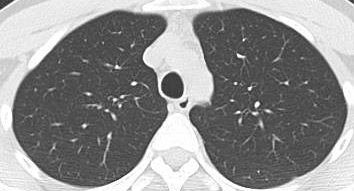

In [3]:
df['Image'][2235]

In [4]:
df['Label'][2235]

'non-COVID'

- Para trabalhar com scikit-learn tinham várias possibilidades de algoritmos, mas preferimos, por testes com outros modelos em outros conjuntos de dados, escolher Random Forests

In [5]:
# convertendo as imagens para uma matriz 2D
# o preprocess_image está convertendo a imagem para o padrao cinza e 128x128.
# o tamanho pode ser alterado nessa linha de código.
flattened_images = [preprocess_image(np.asarray(img), 128).flatten() for img in df['Image']]
X = np.vstack(flattened_images)
y = df['Label'].values

In [6]:
flattened_images[0]

array([193, 198, 194, ..., 255, 255, 255], dtype=uint8)

In [7]:
# dividindo o dataset com 20% para validações
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# treinamento com random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# previsao
y_pred = rf.predict(X_test)

In [10]:
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.8792756539235412

Relatório de Classificação:
               precision    recall  f1-score   support

       COVID       0.92      0.82      0.87       239
   non-COVID       0.85      0.94      0.89       258

    accuracy                           0.88       497
   macro avg       0.89      0.88      0.88       497
weighted avg       0.88      0.88      0.88       497



### Teste utilizando GridSeachCV para seleção automatizada de n_estimators, max_depth e min_samples_split

In [11]:
# definição dos hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],   # quantidade de arvores
    'max_depth': [None, 10, 20, 30],            # profundidade de cada arvore
    'min_samples_split': [2, 5, 10]             # maximo de divisoes por profundidade
}

rf2 = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=3, n_jobs=3, verbose=2)

In [12]:
# ajuste dos modelos aos parametros
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=3,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200, 250]},
             verbose=2)

In [13]:
# verificando os melhores parametros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

Melhores hiperparâmetros: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


In [14]:
# testando o modelo com os melhores parametros
best_rf = grid_search.best_estimator_
y_pred_gs = best_rf.predict(X_test)

In [15]:
print("Acurácia:", accuracy_score(y_test, y_pred_gs))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_gs))

Acurácia: 0.8873239436619719

Relatório de Classificação:
               precision    recall  f1-score   support

       COVID       0.95      0.81      0.87       239
   non-COVID       0.85      0.96      0.90       258

    accuracy                           0.89       497
   macro avg       0.90      0.88      0.89       497
weighted avg       0.89      0.89      0.89       497



- Observa-se que com o uso do GridSeachCV há uma leve melhora no treinamento.
- Abaixo testamos algumas métricas para melhor visualização dos resultados

### Utilizando Data Augmentation com Rotação e Escala

In [16]:
# separando o dataset para novo treinamento
X_aum = df['Image']
y_aum = df['Label']
X_train_aum, X_test_aum, y_train_aum, y_test_aum = train_test_split(X_aum, y_aum, test_size=0.2, random_state=42)

In [17]:
# utilizando as funcoes para gerar mais duas imagens para cada imagem atual com zoom e rotacao
augmented_images = []
augmented_labels = []

for img, label in zip(X_train_aum, y_train_aum):
    # Pré-processa a imagem (redimensiona e converte para escala de cinza)
    preprocessed_img = preprocess_image(np.asarray(img), 128)
    
    # Aplica as transformações de aumento de dados
    rotated_img = random_rotation(preprocessed_img)
    zoomed_img = random_zoom(preprocessed_img)

    # Adiciona as imagens aumentadas à lista e aplana
    augmented_images.append(rotated_img.flatten())
    augmented_images.append(zoomed_img.flatten())

    # Adiciona os rótulos correspondentes
    augmented_labels.extend([label, label])

# Converte a lista de imagens aumentadas para uma matriz NumPy
X_augmented = np.vstack(augmented_images)

# Converte a lista de rótulos para um array NumPy
y_augmented = np.array(augmented_labels)

In [18]:
# treinamento com random forest
rf_aug = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=10, random_state=42)
rf_aug.fit(X_augmented, y_augmented)

RandomForestClassifier(min_samples_split=10, n_estimators=200, random_state=42)

In [19]:
y_pred_aug = rf_aug.predict(X_test)

In [20]:
print("Acurácia:", accuracy_score(y_test_aum, y_pred_aug))
print("\nRelatório de Classificação:\n", classification_report(y_test_aum, y_pred_aug))

Acurácia: 0.8511066398390342

Relatório de Classificação:
               precision    recall  f1-score   support

       COVID       0.89      0.79      0.84       239
   non-COVID       0.82      0.91      0.86       258

    accuracy                           0.85       497
   macro avg       0.86      0.85      0.85       497
weighted avg       0.85      0.85      0.85       497



- Com o aumento dos dados usando zoom e rotação o modelo perdeu um pouco de desempenho. 
- O modelo abaixo será treinado com alteração nos canais de brilho/contraste e flip vertical/horizontal

### Utilizando Data Augmentation com flip horizontal/vertical e alteração de contraste/brilho

In [21]:
augmented_images2 = []
augmented_labels2 = []

for img, label in zip(X_train_aum, y_train_aum):
    preprocessed_img = preprocess_image(np.asarray(img), 128).flatten()  # Achate a imagem aqui

    # Aplica as transformações e achata as imagens transformadas antes de adicioná-las à lista
    augmented_images2.append(horizontal_flip(preprocessed_img).flatten())
    augmented_images2.append(vertical_flip(preprocessed_img).flatten())
    augmented_images2.append(adjust_brightness_contrast(preprocessed_img, alpha=1.2, beta=30).flatten())
    augmented_labels2.extend([label, label, label])


In [22]:
# Converte a lista de imagens aumentadas para uma matriz NumPy
X_augmented2 = np.vstack(augmented_images2)

# Converte a lista de rótulos para um array NumPy
y_augmented2 = np.array(augmented_labels2)

In [23]:
# treinamento com random forest
rf_aug2 = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=10, random_state=42)
rf_aug2.fit(X_augmented2, y_augmented2)

RandomForestClassifier(min_samples_split=10, n_estimators=200, random_state=42)

In [24]:
y_pred_aug2 = rf_aug2.predict(X_test)

In [25]:
print("Acurácia:", accuracy_score(y_test_aum, y_pred_aug2))
print("\nRelatório de Classificação:\n", classification_report(y_test_aum, y_pred_aug2))

Acurácia: 0.8913480885311871

Relatório de Classificação:
               precision    recall  f1-score   support

       COVID       0.95      0.82      0.88       239
   non-COVID       0.85      0.96      0.90       258

    accuracy                           0.89       497
   macro avg       0.90      0.89      0.89       497
weighted avg       0.90      0.89      0.89       497



In [26]:
param_grid_aug = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10]     
}
rf_aug_grid = RandomForestClassifier(random_state=42)
grid_search_aug = GridSearchCV(estimator=rf_aug_grid, param_grid=param_grid_aug, cv=3, n_jobs=4, verbose=2)

In [27]:
grid_search_aug.fit(X_augmented2, y_augmented2)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=2)

In [28]:
# verificando os melhores parametros
best_params_aug = grid_search_aug.best_params_
print("Melhores hiperparâmetros:", best_params_aug)

Melhores hiperparâmetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}


In [29]:
# testando o modelo com os melhores parametros
best_rf_aug = grid_search_aug.best_estimator_
y_pred_gs_aug = best_rf_aug.predict(X_test)

In [30]:
print("Acurácia:", accuracy_score(y_test, y_pred_gs_aug))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_gs_aug))

Acurácia: 0.8993963782696177

Relatório de Classificação:
               precision    recall  f1-score   support

       COVID       0.95      0.83      0.89       239
   non-COVID       0.86      0.96      0.91       258

    accuracy                           0.90       497
   macro avg       0.91      0.90      0.90       497
weighted avg       0.90      0.90      0.90       497



# Métricas dos modelos

### Primeiro treinamento - Com n_estimators igual a 100

In [31]:
acuracias = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
mean = acuracias.mean()
std = acuracias.std()
print(f'Acurácia média na validação cruzada: {mean}')
print(f'Desvio padrão: {std}')

Acurácia média na validação cruzada: 0.8250916791068995
Desvio padrão: 0.061357451249603796


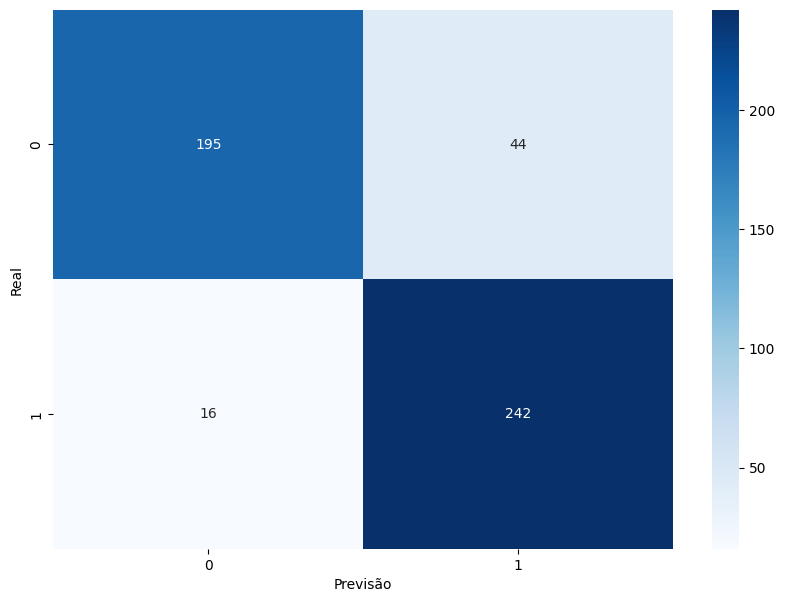

In [32]:
matrix1 = confusion_matrix(y_test, y_pred)

# Visualizando a matriz de confusão usando seaborn
plt.figure(figsize=(10,7))
sns.heatmap(matrix1, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

### Segundo treinamento - Utilizando GridSeachCV

In [33]:
acuracias = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy')
mean = acuracias.mean()
std = acuracias.std()
print(f'Acurácia média na validação cruzada: {mean}')
print(f'Desvio padrão: {std}')

Acurácia média na validação cruzada: 0.8166223145323555
Desvio padrão: 0.06738279838686805


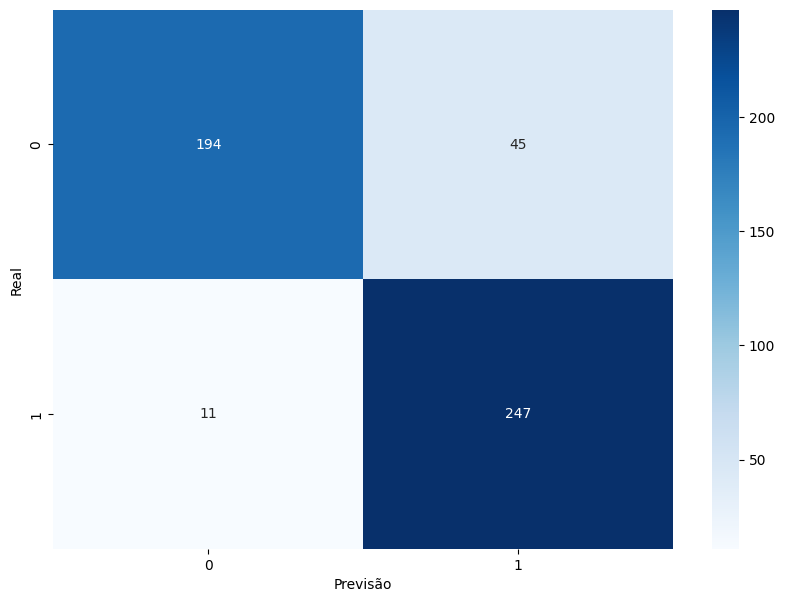

In [34]:
matrix2 = confusion_matrix(y_test, y_pred_gs)

# Visualizando a matriz de confusão usando seaborn
plt.figure(figsize=(10,7))
sns.heatmap(matrix2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

### Terceiro treinamento - Com Data Augmentation rotação/escala e valores encontrados no GridSearchCV

In [35]:
acuracias = cross_val_score(rf_aug, X, y, cv=5, scoring='accuracy')
mean = acuracias.mean()
std = acuracias.std()
print(f'Acurácia média na validação cruzada: {mean}')
print(f'Desvio padrão: {std}')

Acurácia média na validação cruzada: 0.8166223145323555
Desvio padrão: 0.06738279838686805


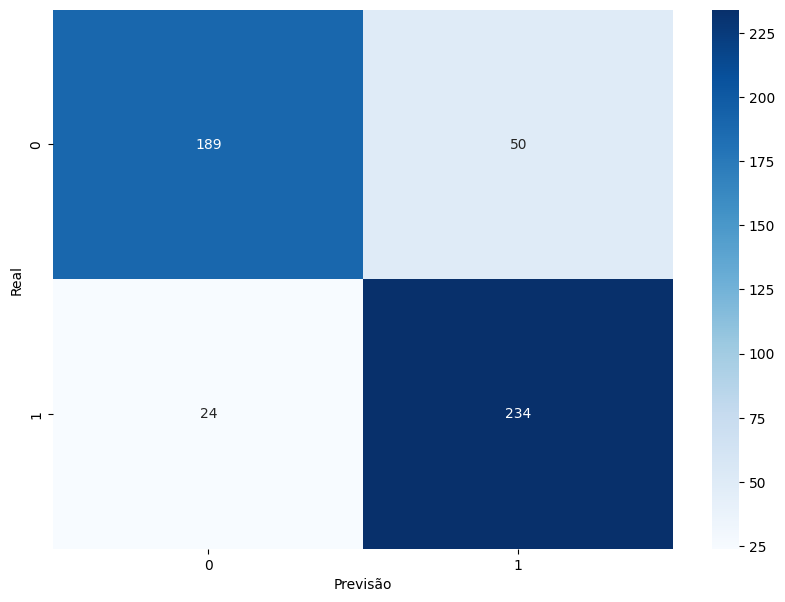

In [36]:
matrix3 = confusion_matrix(y_test, y_pred_aug)

# Visualizando a matriz de confusão usando seaborn
plt.figure(figsize=(10,7))
sns.heatmap(matrix3, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

### Quarto treinamento - Data Augmentation flip horitontal/vertical e brilho/contraste

In [37]:
acuracias = cross_val_score(rf_aug2, X, y, cv=5, scoring='accuracy')
mean = acuracias.mean()
std = acuracias.std()
print(f'Acurácia média na validação cruzada: {mean}')
print(f'Desvio padrão: {std}')

Acurácia média na validação cruzada: 0.8166223145323555
Desvio padrão: 0.06738279838686805


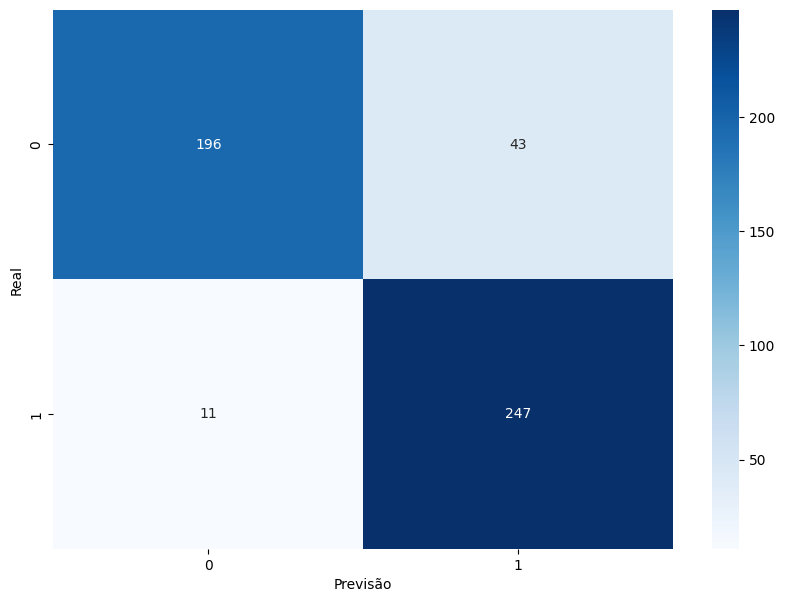

In [38]:
matrix4 = confusion_matrix(y_test, y_pred_aug2)

# Visualizando a matriz de confusão usando seaborn
plt.figure(figsize=(10,7))
sns.heatmap(matrix4, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

### Quinto treinamento - Data Augmentation flip horizontal/vertical + brilho/contraste + novo Grid_Search

In [39]:
acuracias = cross_val_score(best_rf_aug, X, y, cv=5, scoring='accuracy')
mean = acuracias.mean()
std = acuracias.std()
print(f'Acurácia média na validação cruzada: {mean}')
print(f'Desvio padrão: {std}')

Acurácia média na validação cruzada: 0.8299279548257287
Desvio padrão: 0.06124459242693323


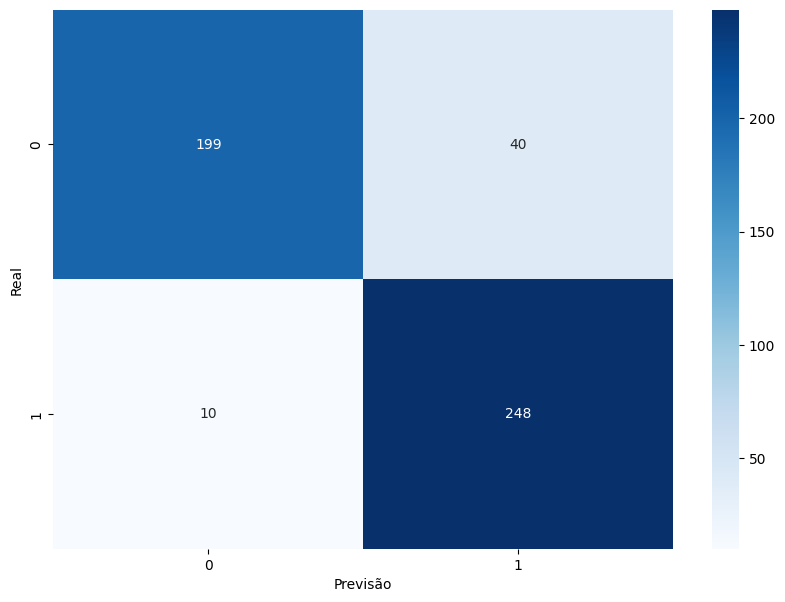

In [40]:
matrix5 = confusion_matrix(y_test, y_pred_gs_aug)

# Visualizando a matriz de confusão usando seaborn
plt.figure(figsize=(10,7))
sns.heatmap(matrix5, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()